# Quantum vs. Classical Implementation of Portfolio optimization using Markowitz Portfolio Theory

## Import Packages

In [1]:
# Optimization modeling
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# QAOA & optimizer
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA

# Aer Sampler primitive for QAOA
from qiskit_aer.primitives import Sampler

# Numerical & stock data libraries
import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import warnings
import time
import itertools
import matplotlib.pyplot as plt
from typing import Dict, Any
import seaborn as sns

# Suppress specific deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="qiskit_aer")

## Data Management

In [2]:
class DataManager:
    """Centralized data management to ensure both optimizers use identical data"""
    
    def __init__(self, days, interval, start):
        self.tickers = [
            'AAPL', 'MSFT', 'NVDA', 'AMZN', 'META', 'GOOGL', 'GOOG', 'TSLA', 
            'AVGO', 'BRK-B', 'JPM', 'LLY', 'UNH', 'XOM', 'V', 'MA', 'PG', 
            'JNJ', 'HD', 'COST', 'NFLX', 'CRM', 'CVX', 'BAC', 'ABBV'
        ]
        self.n = len(self.tickers)
        self.data = self.download_data(days, interval, start)
        self.returns_matrix = None
        self.mu = None
        self.sigma = None
        self._compute_statistics()
    
    def download_data(self, days, interval, start):
        """Download data with proper error handling"""
        start_date = datetime.strptime(start, '%Y-%m-%d')
        calendar_days_needed = int(days * 1.4) + 7
        end_date = start_date + timedelta(days=calendar_days_needed)
        end_date = end_date.strftime('%Y-%m-%d')
        
        print(f"Downloading data from {start} to {end_date} (to get ~{days} trading days)")
        
        data = yf.download(
            tickers=self.tickers, 
            start=start,
            end=end_date, 
            interval=interval,
            auto_adjust=True,
            rounding=True,
            progress=False
        )['Close']
        
        if len(self.tickers) == 1:
            data = pd.DataFrame(data, columns=self.tickers)
        
        if len(data) > days:
            data = data.tail(days)
        
        if data.empty:
            raise ValueError("No data available for the specified period")
        
        actual_days = len(data)
        print(f"Successfully downloaded {actual_days} trading days of data")
        return data
    
    def _compute_statistics(self):
        """Compute returns, expected returns, and covariance matrix"""
        returns = self.data.pct_change().dropna()
        if returns.empty:
            raise ValueError("Insufficient data to compute returns")
        
        self.returns_matrix = returns.to_numpy()
        self.mu = np.mean(self.returns_matrix, axis=0).reshape(-1, 1)
        self.sigma = np.cov(self.returns_matrix.T)

## Quantum Implementation - QAOA using Qiskit

In [3]:
class Quantum:
    def __init__(self, B, data_manager):
        self.tickers = data_manager.tickers
        self.n = data_manager.n
        
        if not (1 <= B <= self.n):
            raise ValueError(f"Budget must be between 1 and {self.n}")
        
        self.B = B
        self.data_manager = data_manager
        
        # Parameters for QUBO formulation
        self.risk_aversion = 1.0
        self.penalty_strength = 10.0

    def build_qubo_matrix(self, mu, sigma, risk_aversion, penalty_strength, B):
        """Build QUBO matrix for portfolio optimization"""
        qubo_matrix = np.zeros((self.n, self.n))
        
        # Diagonal terms
        for i in range(self.n):
            qubo_matrix[i, i] = (risk_aversion * sigma[i, i] - mu[i, 0] + 
                               penalty_strength * (1 - 2 * B))
        
        # Off-diagonal terms
        for i in range(self.n):
            for j in range(i + 1, self.n):
                covariance_term = risk_aversion * sigma[i, j]
                penalty_term = 2 * penalty_strength
                
                qubo_matrix[i, j] = covariance_term + penalty_term
                qubo_matrix[j, i] = covariance_term + penalty_term
        
        return qubo_matrix

    def build_quadratic_program(self, qubo):
        """Build quadratic program for Qiskit optimization"""
        program = QuadraticProgram()

        for i in range(self.n):
            program.binary_var(name=f"x{i}")

        linear = {}
        quadratic = {}

        for i in range(self.n):
            linear[i] = qubo[i, i]

        for i in range(self.n):
            for j in range(i + 1, self.n):
                if qubo[i, j] != 0:
                    quadratic[(i, j)] = qubo[i, j]

        program.minimize(linear=linear, quadratic=quadratic)
        
        program.linear_constraint(
            linear={i: 1 for i in range(self.n)},
            sense="==",
            rhs=self.B,
            name="asset_selection"
        )

        return program

    def quantum_optimizer(self, program, max_iterations=200):
        """Run QAOA optimization"""
        try:
            sampler = Sampler()
            optimizer = COBYLA(maxiter=max_iterations)
            qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=2)

            solver = MinimumEigenOptimizer(qaoa)
            result = solver.solve(program)
        
            return result
        except Exception as e:
            raise Exception(f"Optimization failed: {str(e)}")

    def calculate_portfolio_metrics(self, selected_indices):
        """Calculate portfolio return and risk using the same method as Classical"""
        mu = self.data_manager.mu
        sigma = self.data_manager.sigma
        
        if len(selected_indices) > 0:
            portfolio_return = np.sum([mu[i, 0] for i in selected_indices])
            
            portfolio_variance = 0
            for i in selected_indices:
                for j in selected_indices:
                    portfolio_variance += sigma[i, j]
            
            portfolio_risk = np.sqrt(portfolio_variance)
            
            # Use the SAME objective function as Classical
            objective_value = self.risk_aversion * portfolio_variance - portfolio_return
        else:
            portfolio_return = 0
            portfolio_risk = 0
            objective_value = float('inf')
        
        return portfolio_return, portfolio_risk, objective_value

    def analyze_solution(self, result):
        """Analyze and display the optimization results"""
        if result.x is None:
            print("No solution found")
            return None, None, None, None
        
        x_opt = result.x
        selected_assets = [self.tickers[i] for i in range(self.n) if x_opt[i] == 1]
        selected_indices = [i for i in range(self.n) if x_opt[i] == 1]
        
        portfolio_return, portfolio_risk, objective_value = self.calculate_portfolio_metrics(selected_indices)
        
        return selected_assets, portfolio_return, portfolio_risk, objective_value

    def optimization(self):
        """Run the complete optimization process"""
        print("Computing returns and statistics...")
        
        mu = self.data_manager.mu
        sigma = self.data_manager.sigma
        
        print(f"Expected returns: {mu.flatten()}")
        print(f"Risk (std dev): {np.sqrt(np.diag(sigma))}")
        
        # Build QUBO matrix
        qubo_matrix = self.build_qubo_matrix(mu, sigma, self.risk_aversion, self.penalty_strength, self.B)
        
        # Create optimization program
        program = self.build_quadratic_program(qubo_matrix)
        
        print("Running QAOA optimization...")
        
        # Run optimization
        result = self.quantum_optimizer(program)
        
        # Analyze results
        selected_assets, portfolio_return, portfolio_risk, objective_value = self.analyze_solution(result)
        
        return {
            'selected_assets': selected_assets,
            'portfolio_return': portfolio_return,
            'portfolio_risk': portfolio_risk,
            'objective_value': objective_value,
            'mu': mu,
            'sigma': sigma
        }

## Classical Implementation - Brute Force

In [4]:
class Classical:
    def __init__(self, B, data_manager):
        self.tickers = data_manager.tickers
        self.n = data_manager.n
        
        if not (1 <= B <= self.n):
            raise ValueError(f"Budget must be between 1 and {self.n}")
        
        self.B = B
        self.data_manager = data_manager
        self.risk_aversion = 1.0  # Same as Quantum
    
    def optimization(self):
        print("Optimizing Classically using Brute Force:")

        mu = self.data_manager.mu
        sigma = self.data_manager.sigma

        best_combination = None
        best_objective = float('inf')
        best_return = 0
        best_risk = 0

        for k in itertools.combinations(range(self.n), self.B):
            # Calculate Portfolio return
            portfolio_return = np.sum([mu[i, 0] for i in k])

            # Calculate portfolio risk (variance)
            portfolio_variance = 0
            for i in k:
                for j in k:
                    portfolio_variance += sigma[i, j]
            
            portfolio_risk = np.sqrt(portfolio_variance)

            # Objective function: SAME as Quantum (minimize risk - return)
            objective = self.risk_aversion * portfolio_variance - portfolio_return
            
            if objective < best_objective:
                best_objective = objective
                best_combination = k
                best_return = portfolio_return
                best_risk = portfolio_risk

        selected_assets = [self.tickers[i] for i in best_combination]

        return {
            'selected_assets': selected_assets,
            'portfolio_return': best_return,
            'portfolio_risk': best_risk,
            'objective_value': best_objective,
            'mu': mu,
            'sigma': sigma
        }

## Compare QAOA vs Brute Force

QUANTUM VS CLASSICAL PORTFOLIO OPTIMIZATION

PORTFOLIO OPTIMIZATION COMPARISON
Problem Setup:
Select 15 assets from the Magnificent 7 stocks
Using 50 trading days from 2024-01-01
Data interval: 1d

Initializing shared data manager...
Successfully downloaded 50 trading days of data
Initializing optimizers...

Running Quantum QAOA Optimization...
Computing returns and statistics...
Expected returns: [-0.00097915  0.00221173  0.00399132  0.00365211  0.0011722   0.00238475
  0.00243743  0.00340526  0.00094994  0.00076286  0.00086586  0.00216518
 -0.00013335  0.00216901  0.00436924  0.00264307  0.00735143  0.00264893
  0.00520688  0.01296056  0.00184211 -0.00717618 -0.00197982  0.00184023
  0.00196995]
Risk (std dev): [0.01150599 0.00887999 0.01786733 0.02515991 0.01275442 0.0076509
 0.01454722 0.01710316 0.01249246 0.01790392 0.01795189 0.01041653
 0.00725882 0.00816837 0.01726744 0.01002771 0.03396953 0.01291976
 0.02126163 0.03434223 0.00855206 0.02959943 0.01353691 0.00869217
 0.0118240

C:\Users\adity\AppData\Local\Temp\ipykernel_7588\2435226886.py:136: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result = self.quantum_optimizer(program)


Quantum optimization completed in 711.2094 seconds

Running Classical Brute Force Optimization...
Optimizing Classically using Brute Force:
Classical optimization completed in 199.8256 seconds

DETAILED COMPARISON ANALYSIS
Portfolio Return Analysis:
   Quantum:   0.025314
   Classical: 0.056948
   Difference: -55.55%
   Winner: Classical

Portfolio Risk Analysis:
   Quantum:   0.104764
   Classical: 0.129514
   Difference: -19.11%
   Lower Risk: Quantum

Objective Function Analysis (Lower = Better):
   Quantum:   -0.014339
   Classical: -0.040174
   Difference: +64.31%
   Winner: Classical

Execution Time Analysis:
   Quantum:   711.2094 seconds
   Classical: 199.8256 seconds
   Speed Ratio (Q/C): 3.56x
   Faster: Classical

Portfolio Composition Analysis:
   Quantum Selected:   ['AAPL', 'AVGO', 'BAC', 'BRK-B', 'CVX', 'GOOG', 'GOOGL', 'JPM', 'LLY', 'MA', 'META', 'NFLX', 'NVDA', 'PG', 'UNH']
   Classical Selected: ['ABBV', 'BAC', 'COST', 'GOOG', 'GOOGL', 'HD', 'LLY', 'MA', 'MSFT', 'NFLX

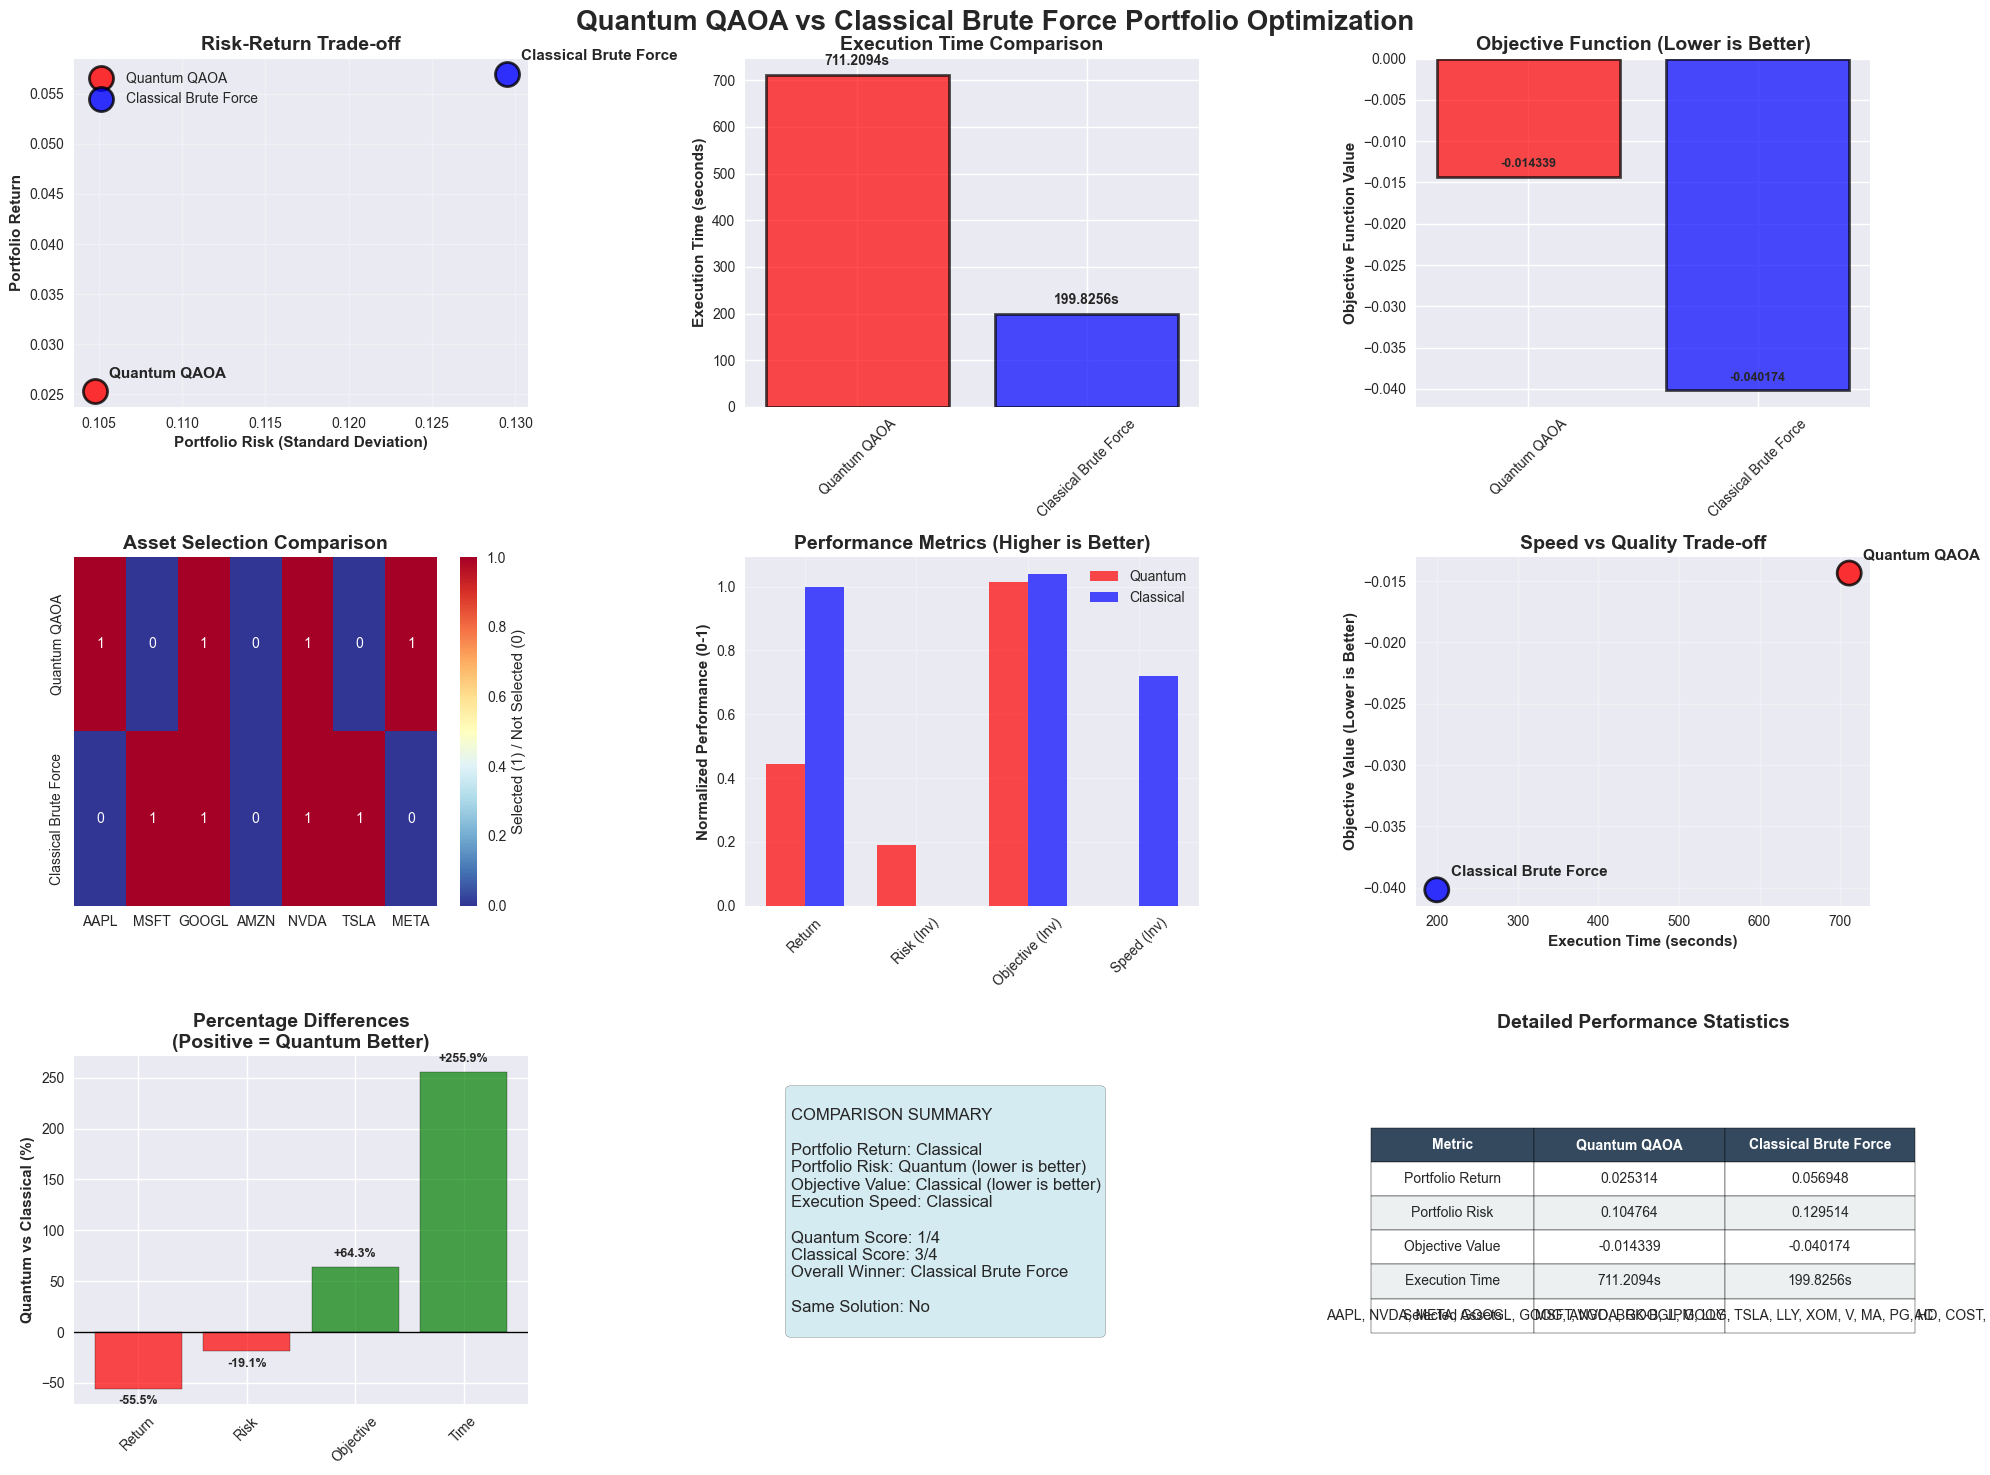


Comparison completed successfully!
Check the generated visualization for detailed insights.


In [5]:
def run_portfolio_comparison(B, days, interval, start):    
    print("PORTFOLIO OPTIMIZATION COMPARISON")
    print("=" * 60)
    print(f"Problem Setup:")
    print(f"Select {B} assets from the Magnificent 7 stocks")
    print(f"Using {days} trading days from {start}")
    print(f"Data interval: {interval}")
    print("=" * 60)
    
    # Initialize shared data manager
    print("\nInitializing shared data manager...")
    data_manager = DataManager(days, interval, start)
    
    # Initialize optimizers with shared data
    print("Initializing optimizers...")    
    quantum_opt = Quantum(B, data_manager)
    classical_opt = Classical(B, data_manager)
    
    # Run Quantum Optimization
    print("\nRunning Quantum QAOA Optimization...")
    start_time = time.time()
    try:
        quantum_results = quantum_opt.optimization()
        quantum_results['execution_time'] = time.time() - start_time
        quantum_results['method'] = 'Quantum QAOA'
        print(f"Quantum optimization completed in {quantum_results['execution_time']:.4f} seconds")
    except Exception as e:
        print(f"Quantum optimization failed: {str(e)}")
        quantum_results = None
    
    # Run Classical Optimization
    print("\nRunning Classical Brute Force Optimization...")
    start_time = time.time()
    try:
        classical_results = classical_opt.optimization()
        classical_results['execution_time'] = time.time() - start_time
        classical_results['method'] = 'Classical Brute Force'
        print(f"Classical optimization completed in {classical_results['execution_time']:.4f} seconds")
    except Exception as e:
        print(f"Classical optimization failed: {str(e)}")
        classical_results = None
    
    # Perform comparison analysis
    if quantum_results and classical_results:
        comparison_metrics = analyze_comparison(quantum_results, classical_results)
        visualization = create_comprehensive_visualization(quantum_results, classical_results, comparison_metrics)
        
        return {
            'quantum_results': quantum_results,
            'classical_results': classical_results,
            'comparison_metrics': comparison_metrics,
            'visualization': visualization
        }
    else:
        print("Cannot perform comparison - one or both optimizations failed")
        return None

def analyze_comparison(quantum_results, classical_results):
    """Comprehensive analysis comparing quantum and classical results"""
    
    print("\nDETAILED COMPARISON ANALYSIS")
    print("=" * 60)
    
    # Extract key metrics
    q_return = quantum_results['portfolio_return']
    c_return = classical_results['portfolio_return']
    q_risk = quantum_results['portfolio_risk']
    c_risk = classical_results['portfolio_risk']
    q_objective = quantum_results['objective_value']
    c_objective = classical_results['objective_value']
    q_time = quantum_results['execution_time']
    c_time = classical_results['execution_time']
    q_assets = set(quantum_results['selected_assets'])
    c_assets = set(classical_results['selected_assets'])
    
    # Calculate percentage differences
    return_diff_pct = ((q_return - c_return) / abs(c_return)) * 100 if c_return != 0 else 0
    risk_diff_pct = ((q_risk - c_risk) / c_risk) * 100 if c_risk != 0 else 0
    obj_diff_pct = ((q_objective - c_objective) / abs(c_objective)) * 100 if c_objective != 0 else 0
    time_ratio = q_time / c_time if c_time != 0 else float('inf')
    
    # Define tolerance for ties
    tolerance = 1e-8
    
    # Determine winners with tie handling
    if abs(q_return - c_return) < tolerance:
        better_return = "Tie"
    else:
        better_return = "Quantum" if q_return > c_return else "Classical"
    
    if abs(q_risk - c_risk) < tolerance:
        better_risk = "Tie"
    else:
        better_risk = "Quantum" if q_risk < c_risk else "Classical"
    
    if abs(q_objective - c_objective) < tolerance:
        better_objective = "Tie"
    else:
        better_objective = "Quantum" if q_objective < c_objective else "Classical"
    
    if abs(q_time - c_time) < tolerance:
        faster_method = "Tie"
    else:
        faster_method = "Quantum" if q_time < c_time else "Classical"
    
    # Solution similarity
    same_solution = q_assets == c_assets
    common_assets = q_assets.intersection(c_assets)
    unique_quantum = q_assets - c_assets
    unique_classical = c_assets - q_assets
    
    # Print detailed analysis
    print(f"Portfolio Return Analysis:")
    print(f"   Quantum:   {q_return:.6f}")
    print(f"   Classical: {c_return:.6f}")
    print(f"   Difference: {return_diff_pct:+.2f}%")
    print(f"   Winner: {better_return}")
    print()
    
    print(f"Portfolio Risk Analysis:")
    print(f"   Quantum:   {q_risk:.6f}")
    print(f"   Classical: {c_risk:.6f}")
    print(f"   Difference: {risk_diff_pct:+.2f}%")
    print(f"   Lower Risk: {better_risk}")
    print()
    
    print(f"Objective Function Analysis (Lower = Better):")
    print(f"   Quantum:   {q_objective:.6f}")
    print(f"   Classical: {c_objective:.6f}")
    print(f"   Difference: {obj_diff_pct:+.2f}%")
    print(f"   Winner: {better_objective}")
    print()
    
    print(f"Execution Time Analysis:")
    print(f"   Quantum:   {q_time:.4f} seconds")
    print(f"   Classical: {c_time:.4f} seconds")
    print(f"   Speed Ratio (Q/C): {time_ratio:.2f}x")
    print(f"   Faster: {faster_method}")
    print()
    
    print(f"Portfolio Composition Analysis:")
    print(f"   Quantum Selected:   {sorted(list(q_assets))}")
    print(f"   Classical Selected: {sorted(list(c_assets))}")
    print(f"   Identical Solutions: {'Yes' if same_solution else 'No'}")
    print(f"   Common Assets: {sorted(list(common_assets))}")
    if unique_quantum:
        print(f"Only in Quantum: {sorted(list(unique_quantum))}")
    if unique_classical:
        print(f"Only in Classical: {sorted(list(unique_classical))}")
    print()
    
    # Overall assessment with updated scoring
    print(f"OVERALL ASSESSMENT:")
    
    quantum_score = 0
    classical_score = 0
    
    # Return comparison
    if better_return == "Quantum":
        quantum_score += 1
    elif better_return == "Classical":
        classical_score += 1
    else:  # Tie
        quantum_score += 1
        classical_score += 1
    
    # Risk comparison
    if better_risk == "Quantum":
        quantum_score += 1
    elif better_risk == "Classical":
        classical_score += 1
    else:  # Tie
        quantum_score += 1
        classical_score += 1
    
    # Objective comparison
    if better_objective == "Quantum":
        quantum_score += 1
    elif better_objective == "Classical":
        classical_score += 1
    else:  # Tie
        quantum_score += 1
        classical_score += 1
    
    # Time comparison
    if faster_method == "Quantum":
        quantum_score += 1
    elif faster_method == "Classical":
        classical_score += 1
    else:  # Tie
        quantum_score += 1
        classical_score += 1
    
    print(f"   Quantum score: {quantum_score}/4")
    print(f"   Classical score: {classical_score}/4")
    
    if quantum_score > classical_score:
        overall_winner = "Quantum QAOA"
    elif classical_score > quantum_score:
        overall_winner = "Classical Brute Force"
    else:
        overall_winner = "Tie"
    
    print(f"   Overall Winner: {overall_winner}")
    print()
    
    comparison_metrics = {
        'return_difference_pct': return_diff_pct,
        'risk_difference_pct': risk_diff_pct,
        'objective_difference_pct': obj_diff_pct,
        'time_ratio': time_ratio,
        'better_return': better_return,
        'better_risk': better_risk,
        'better_objective': better_objective,
        'faster_method': faster_method,
        'same_solution': same_solution,
        'common_assets': list(common_assets),
        'unique_quantum': list(unique_quantum),
        'unique_classical': list(unique_classical),
        'quantum_score': quantum_score,
        'classical_score': classical_score,
        'overall_winner': overall_winner,
        'tolerance_used': tolerance
    }
    
    return comparison_metrics

def create_comprehensive_visualization(quantum_results, classical_results, comparison_metrics):
    """Create comprehensive visualization comparing both methods"""
    
    # Set up the plotting style
    try:
        plt.style.use('seaborn-v0_8')
    except OSError:
        try:
            plt.style.use('seaborn')
        except OSError:
            plt.style.use('default')
    
    colors = ['red', 'blue']
    
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('Quantum QAOA vs Classical Brute Force Portfolio Optimization', 
                 fontsize=20, fontweight='bold', y=0.98)
    
    methods = ['Quantum QAOA', 'Classical Brute Force']
    
    q = quantum_results
    c = classical_results
    
    returns = [q['portfolio_return'], c['portfolio_return']]
    risks = [q['portfolio_risk'], c['portfolio_risk']]
    objectives = [q['objective_value'], c['objective_value']]
    times = [q['execution_time'], c['execution_time']]
    
    # 1. Risk-Return Scatter Plot
    ax1 = plt.subplot(3, 3, 1)
    for i, method in enumerate(methods):
        ax1.scatter(risks[i], returns[i], s=300, alpha=0.8, 
                   color=colors[i], label=method, edgecolors='black', linewidth=2)
        ax1.annotate(method, (risks[i], returns[i]), 
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=11, fontweight='bold')
    
    ax1.set_xlabel('Portfolio Risk (Standard Deviation)', fontweight='bold')
    ax1.set_ylabel('Portfolio Return', fontweight='bold')
    ax1.set_title('Risk-Return Trade-off', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 2. Execution Time Comparison
    ax2 = plt.subplot(3, 3, 2)
    bars = ax2.bar(methods, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Execution Time (seconds)', fontweight='bold')
    ax2.set_title('Execution Time Comparison', fontweight='bold', fontsize=14)
    ax2.tick_params(axis='x', rotation=45)
    
    for bar, time_val in zip(bars, times):
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2, height + max(times)*0.02,
                    f'{time_val:.4f}s', ha='center', va='bottom', fontweight='bold')
    
    # 3. Objective Function Values
    ax3 = plt.subplot(3, 3, 3)
    bars = ax3.bar(methods, objectives, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax3.set_ylabel('Objective Function Value', fontweight='bold')
    ax3.set_title('Objective Function (Lower is Better)', fontweight='bold', fontsize=14)
    ax3.tick_params(axis='x', rotation=45)
    
    for bar, obj_val in zip(bars, objectives):
        height = bar.get_height()
        if height != 0:
            offset = max(objectives)*0.02 if max(objectives) > 0 else abs(min(objectives))*0.02
            ax3.text(bar.get_x() + bar.get_width()/2, height + offset,
                    f'{obj_val:.6f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 4. Portfolio Composition Heatmap
    ax4 = plt.subplot(3, 3, 4)
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META']
    
    selection_matrix = []
    for result in [q, c]:
        row = [1 if ticker in result['selected_assets'] else 0 for ticker in tickers]
        selection_matrix.append(row)
    
    try:
        sns.heatmap(selection_matrix, 
                    xticklabels=tickers,
                    yticklabels=methods,
                    cmap='RdYlBu_r',
                    annot=True,
                    fmt='.0f',
                    cbar_kws={'label': 'Selected (1) / Not Selected (0)'},
                    ax=ax4)
    except:
        im = ax4.imshow(selection_matrix, cmap='RdYlBu_r', aspect='auto')
        ax4.set_xticks(range(len(tickers)))
        ax4.set_xticklabels(tickers)
        ax4.set_yticks(range(len(methods)))
        ax4.set_yticklabels(methods)
        
        for i in range(len(methods)):
            for j in range(len(tickers)):
                ax4.text(j, i, str(selection_matrix[i][j]), 
                        ha='center', va='center', fontweight='bold')
        
        plt.colorbar(im, ax=ax4, label='Selected (1) / Not Selected (0)')
    
    ax4.set_title('Asset Selection Comparison', fontweight='bold', fontsize=14)
    
    # 5. Performance Metrics Bar Chart
    ax5 = plt.subplot(3, 3, 5)
    
    max_return = max(returns) if max(returns) > 0 else 1
    max_risk = max(risks) if max(risks) > 0 else 1
    max_obj = max(objectives) if max(objectives) > 0 else 1
    max_time = max(times) if max(times) > 0 else 1
    
    norm_returns = [r/max_return for r in returns]
    norm_risks = [1 - r/max_risk for r in risks]
    norm_objectives = [1 - o/max_obj for o in objectives]
    norm_times = [1 - t/max_time for t in times]
    
    metrics_labels = ['Return', 'Risk (Inv)', 'Objective (Inv)', 'Speed (Inv)']
    
    x = np.arange(len(metrics_labels))
    width = 0.35
    
    quantum_scores = [norm_returns[0], norm_risks[0], norm_objectives[0], norm_times[0]]
    classical_scores = [norm_returns[1], norm_risks[1], norm_objectives[1], norm_times[1]]
    
    ax5.bar(x - width/2, quantum_scores, width, label='Quantum', color=colors[0], alpha=0.7)
    ax5.bar(x + width/2, classical_scores, width, label='Classical', color=colors[1], alpha=0.7)
    
    ax5.set_ylabel('Normalized Performance (0-1)', fontweight='bold')
    ax5.set_title('Performance Metrics (Higher is Better)', fontweight='bold', fontsize=14)
    ax5.set_xticks(x)
    ax5.set_xticklabels(metrics_labels, rotation=45)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Time vs Quality Trade-off
    ax6 = plt.subplot(3, 3, 6)
    
    ax6.scatter(times, objectives, s=300, c=colors, alpha=0.8, edgecolors='black', linewidth=2)
    for i, method in enumerate(methods):
        ax6.annotate(method, (times[i], objectives[i]), 
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=11, fontweight='bold')
    
    ax6.set_xlabel('Execution Time (seconds)', fontweight='bold')
    ax6.set_ylabel('Objective Value (Lower is Better)', fontweight='bold')
    ax6.set_title('Speed vs Quality Trade-off', fontweight='bold', fontsize=14)
    ax6.grid(True, alpha=0.3)
    
    # 7. Percentage Differences
    ax7 = plt.subplot(3, 3, 7)
    
    metrics_names = ['Return', 'Risk', 'Objective', 'Time']
    differences = [
        comparison_metrics['return_difference_pct'],
        comparison_metrics['risk_difference_pct'],
        comparison_metrics['objective_difference_pct'],
        (comparison_metrics['time_ratio'] - 1) * 100
    ]
    
    bar_colors = ['green' if d > 0 else 'red' for d in differences]
    bars = ax7.bar(metrics_names, differences, color=bar_colors, alpha=0.7, edgecolor='black')
    ax7.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax7.set_ylabel('Quantum vs Classical (%)', fontweight='bold')
    ax7.set_title('Percentage Differences\n(Positive = Quantum Better)', fontweight='bold', fontsize=14)
    ax7.tick_params(axis='x', rotation=45)
    
    diff_range = max(differences) - min(differences) if differences else 1
    for bar, diff in zip(bars, differences):
        height = bar.get_height()
        offset = diff_range * 0.02 if height >= 0 else -diff_range * 0.02
        ax7.text(bar.get_x() + bar.get_width()/2, height + offset,
                f'{diff:+.1f}%', ha='center', va='bottom' if height >= 0 else 'top', 
                fontweight='bold', fontsize=9)
    
    # 8. Winner Summary
    ax8 = plt.subplot(3, 3, 8)
    ax8.axis('off')
    
    winner_text = f"""
COMPARISON SUMMARY

Portfolio Return: {comparison_metrics['better_return']}
Portfolio Risk: {comparison_metrics['better_risk']} (lower is better)
Objective Value: {comparison_metrics['better_objective']} (lower is better)
Execution Speed: {comparison_metrics['faster_method']}

Quantum Score: {comparison_metrics['quantum_score']}/4
Classical Score: {comparison_metrics['classical_score']}/4
Overall Winner: {comparison_metrics['overall_winner']}

Same Solution: {'Yes' if comparison_metrics['same_solution'] else 'No'}
"""
    
    ax8.text(0.1, 0.9, winner_text, transform=ax8.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.5))
    
    # 9. Detailed Statistics Table
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('tight')
    ax9.axis('off')
    
    table_data = [
        ['Portfolio Return', f'{q["portfolio_return"]:.6f}', f'{c["portfolio_return"]:.6f}'],
        ['Portfolio Risk', f'{q["portfolio_risk"]:.6f}', f'{c["portfolio_risk"]:.6f}'],
        ['Objective Value', f'{q["objective_value"]:.6f}', f'{c["objective_value"]:.6f}'],
        ['Execution Time', f'{q["execution_time"]:.4f}s', f'{c["execution_time"]:.4f}s'],
        ['Selected Assets', ', '.join(q['selected_assets']), ', '.join(c['selected_assets'])]
    ]
    
    table = ax9.table(cellText=table_data,
                     colLabels=['Metric', 'Quantum QAOA', 'Classical Brute Force'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.3, 0.35, 0.35])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)
    
    # Style the table
    for i in range(len(table_data) + 1):
        for j in range(3):
            cell = table[(i, j)]
            if i == 0:  # Header row
                cell.set_facecolor('#34495e')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#ecf0f1' if i % 2 == 0 else 'white')
    
    ax9.set_title('Detailed Performance Statistics', fontweight='bold', fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Main execution function
if __name__ == "__main__":
    print("QUANTUM VS CLASSICAL PORTFOLIO OPTIMIZATION")
    print("=" * 60)
    print()
    
    # Run demonstration
    demo_results = run_portfolio_comparison(B=15, days=50, interval='1d', start='2024-01-01')
    
    if demo_results:
        print("\nComparison completed successfully!")
        print("Check the generated visualization for detailed insights.")
    else:
        print("\nComparison failed.")